In [1]:
# Combining the large traffic dataset with the Motorcycle KSI dataset
import pandas as pd

# load the large traffic dataset
large_traffic_df = pd.read_csv("C:/Users/sarah/AAASemester5Classes/COMP309DataFiles/Traffic_Collisions_Open_Data_1887845723801164272.csv")

# filter for motorcycle PD only collisons
motorcycle_pdo_df = large_traffic_df[
    (large_traffic_df['MOTORCYCLE'] == 'YES') & (large_traffic_df['PD_COLLISIONS'] == 'YES')
]

# get the count of motorcycle PD only collisions
pdo_count = motorcycle_pdo_df.shape[0]

# display filtered data info and count
pdo_count, motorcycle_pdo_df.head()


(2101,
       OBJECTID EVENT_UNIQUE_ID              OCC_DATE OCC_MONTH    OCC_DOW  \
 579        580  GO-20148000468   1/4/2014 5:00:00 AM   January   Saturday   
 953        954  GO-20148000755   1/6/2014 5:00:00 AM   January     Monday   
 2542      2543  GO-20148001855  1/14/2014 5:00:00 AM   January    Tuesday   
 3473      3474  GO-20148002625  1/20/2014 5:00:00 AM   January     Monday   
 4007      4008  GO-20148002984  1/22/2014 5:00:00 AM   January  Wednesday   
 
       OCC_YEAR  OCC_HOUR DIVISION  FATALITIES INJURY_COLLISIONS  ...  \
 579       2014        14      D41           0                NO  ...   
 953       2014        15      D53           0                NO  ...   
 2542      2014         8      D31           0                NO  ...   
 3473      2014        13      D42           0                NO  ...   
 4007      2014         9      NSA           0                NO  ...   
 
                  NEIGHBOURHOOD_158 LONG_WGS84  LAT_WGS84 AUTOMOBILE  \
 579       

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# load the datasets
large_traffic_df = pd.read_csv("C:/Users/sarah/AAASemester5Classes/COMP309DataFiles/Traffic_Collisions_Open_Data_1887845723801164272.csv")
ksi_data = pd.read_csv("C:/Users/sarah/AAASemester5Classes/COMP309DataFiles/MOTORCYCLIST_KSI.csv")

# preprocess the large traffic dataset (PD collisions only)
motorcycle_pdo_df = large_traffic_df[
    (large_traffic_df['MOTORCYCLE'] == 'YES') & (large_traffic_df['PD_COLLISIONS'] == 'YES')
].copy()

# add calculated features to the PDO dataset
TORONTO_CENTER_LAT = 43.6532
TORONTO_CENTER_LONG = -79.3832
motorcycle_pdo_df['Distance_From_Center'] = np.sqrt(
    (motorcycle_pdo_df['LAT_WGS84'] - TORONTO_CENTER_LAT)**2 +
    (motorcycle_pdo_df['LONG_WGS84'] - TORONTO_CENTER_LONG)**2
)
motorcycle_pdo_df['Hour'] = motorcycle_pdo_df['OCC_HOUR']
motorcycle_pdo_df['DayOfWeek'] = pd.to_datetime(motorcycle_pdo_df['OCC_DATE']).dt.dayofweek
motorcycle_pdo_df['IsWeekend'] = motorcycle_pdo_df['DayOfWeek'].isin([5, 6]).astype(int)
motorcycle_pdo_df['IsNightHour'] = motorcycle_pdo_df['Hour'].isin(range(22, 24 + 4)).astype(int)
motorcycle_pdo_df['IsPeakHour'] = motorcycle_pdo_df['Hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)
motorcycle_pdo_df['Severity'] = 0  # Property damage-only

# preprocess the KSI dataset
ksi_data['Distance_From_Center'] = np.sqrt(
    (ksi_data['LATITUDE'] - TORONTO_CENTER_LAT)**2 +
    (ksi_data['LONGITUDE'] - TORONTO_CENTER_LONG)**2
)
ksi_data['Hour'] = ksi_data['TIME'] // 100
ksi_data['DayOfWeek'] = pd.to_datetime(ksi_data['DATE']).dt.dayofweek
ksi_data['IsWeekend'] = ksi_data['DayOfWeek'].isin([5, 6]).astype(int)
ksi_data['IsNightHour'] = ksi_data['Hour'].isin(range(22, 24 + 4)).astype(int)
ksi_data['IsPeakHour'] = ksi_data['Hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)
ksi_data['Severity'] = 1  # Fatal/Injury collisions

# select shared features
selected_columns = [
    'Hour', 'DayOfWeek', 'IsWeekend', 'IsNightHour', 'IsPeakHour', 'Distance_From_Center', 'Severity'
]
pdo_data = motorcycle_pdo_df[selected_columns]
ksi_data = ksi_data[selected_columns]

# combine the datasets
combined_data = pd.concat([pdo_data, ksi_data], ignore_index=True)

# split the data into features and target
X = combined_data.drop('Severity', axis=1)
y = combined_data['Severity']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# initialize and train a random forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100, max_depth=10, random_state=42, class_weight='balanced'
)
rf_model.fit(X_train, y_train)

# evaluate the model
y_pred = rf_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# feature importance
feature_importances = list(zip(X.columns, rf_model.feature_importances_))
print("\nFeature Importances:\n", feature_importances)


Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.70      0.73       420
           1       0.66      0.74      0.70       337

    accuracy                           0.71       757
   macro avg       0.71      0.72      0.71       757
weighted avg       0.72      0.71      0.71       757


Confusion Matrix:
 [[292 128]
 [ 89 248]]

Feature Importances:
 [('Hour', 0.22291397649147393), ('DayOfWeek', 0.09036145226760185), ('IsWeekend', 0.019363732759976084), ('IsNightHour', 0.024628076971168245), ('IsPeakHour', 0.013674951483882106), ('Distance_From_Center', 0.6290578100258979)]


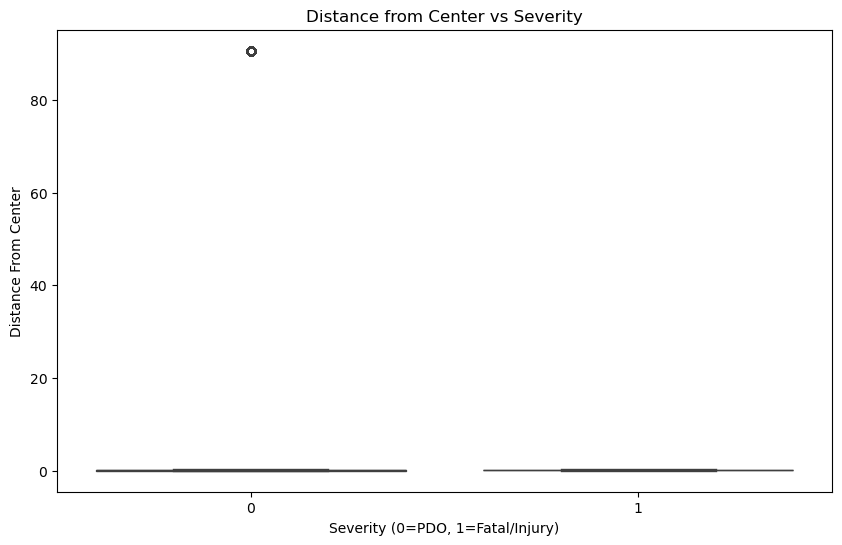

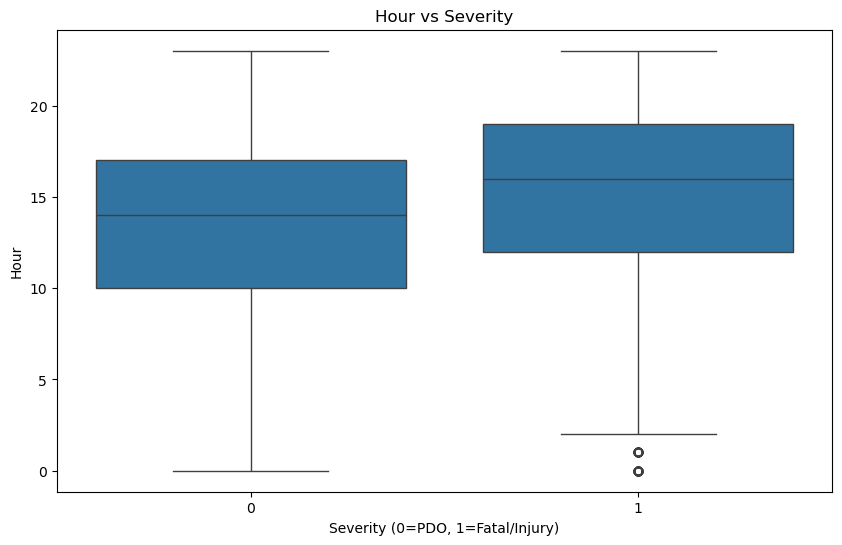

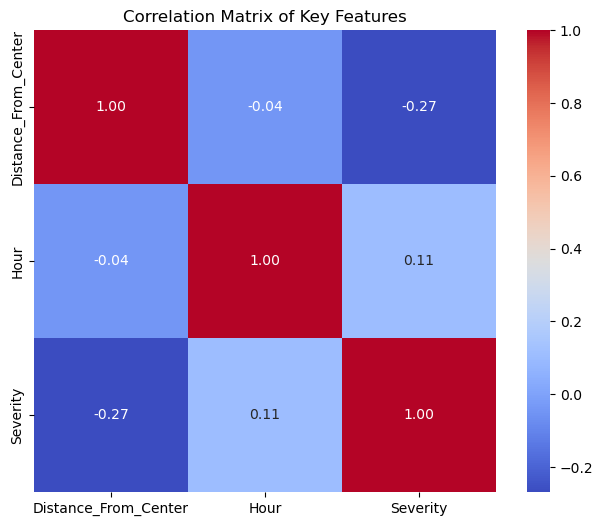

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# visualize distance form center vs severity
plt.figure(figsize=(10,6))
sns.boxplot(x='Severity', y='Distance_From_Center', data=combined_data)
plt.title('Distance from Center vs Severity')
plt.xlabel('Severity (0=PDO, 1=Fatal/Injury)')
plt.ylabel('Distance From Center')
plt.show()

# visualize hour vs severity
plt.figure(figsize=(10,6))
sns.boxplot(x='Severity', y='Hour', data=combined_data)
plt.title('Hour vs Severity')
plt.xlabel('Severity (0=PDO, 1=Fatal/Injury)')
plt.ylabel('Hour')
plt.show()

# correlation heatmap with key features
key_features = ['Distance_From_Center', 'Hour', 'Severity']
correlation_matrix = combined_data[key_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title('Correlation Matrix of Key Features')
plt.show()

In [4]:
# Feature Engineering
""" Create interactions to enhance the dataset:
    Interaction: Distance_From_Center * Hour (does the effect of distance vary by time?).
    Binning: Group Hour into broader ranges (e.g., morning, afternoon, evening, night).
    Normalize Distance_From_Center to improve model interpretability."""

# Interaction term
combined_data['Distance_Hour_Interaction'] = combined_data['DayOfWeek'] * combined_data['Hour']

# Binning hour into broader time ranges
def time_of_day(hour):
    if 5 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 16:
        return 'Afternoon'
    elif 17 <= hour <= 20:
        return 'Evening'
    else:
        return 'Night'

combined_data['TimeOfDay'] = combined_data['Hour'].apply(time_of_day)

# One-hot encode the TimeOfDay feature
combined_data = pd.get_dummies(combined_data, columns=['TimeOfDay'], drop_first=False)

# Normalize Distance_From_Center
combined_data['Distance_From_Center_Normalized'] = (
    combined_data['Distance_From_Center'] - combined_data['Distance_From_Center'].mean()
) / combined_data['Distance_From_Center'].std()

# Verify the resulting columns
print(combined_data.columns)

# Display the updated dataset
combined_data.head()

Index(['Hour', 'DayOfWeek', 'IsWeekend', 'IsNightHour', 'IsPeakHour',
       'Distance_From_Center', 'Severity', 'Distance_Hour_Interaction',
       'TimeOfDay_Afternoon', 'TimeOfDay_Evening', 'TimeOfDay_Morning',
       'TimeOfDay_Night', 'Distance_From_Center_Normalized'],
      dtype='object')


,Hour,DayOfWeek,IsWeekend,IsNightHour,IsPeakHour,Distance_From_Center,Severity,Distance_Hour_Interaction,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,Distance_From_Center_Normalized
0,14,5,1,0,0,0.129691,0,70,True,False,False,False,-0.300030
1,15,0,0,0,0,0.067626,0,0,True,False,False,False,-0.302513
2,8,1,0,0,1,0.150291,0,8,False,False,True,False,-0.299206
3,13,0,0,0,0,0.201201,0,0,True,False,False,False,-0.297170
4,9,2,0,0,1,90.594119,0,18,False,False,True,False,3.318568


In [5]:
# experiment with gradient boosting model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Select features and target variable
engineered_features = [
     'Distance_From_Center', 'Hour', 'Distance_Hour_Interaction',
    'Distance_From_Center_Normalized', 
    'TimeOfDay_Morning', 'TimeOfDay_Afternoon', 'TimeOfDay_Evening', 'TimeOfDay_Night'
]
X = combined_data[engineered_features]
y = combined_data['Severity']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = gb_model.predict(X_test)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("\nGradient Boosting Model Performance:")
print(classification_rep)
print("\nConfusion Matrix:")
print(confusion_mat)



Gradient Boosting Model Performance:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       420
           1       0.75      0.80      0.77       337

    accuracy                           0.79       757
   macro avg       0.79      0.79      0.79       757
weighted avg       0.79      0.79      0.79       757


Confusion Matrix:
[[330  90]
 [ 69 268]]


In [6]:
print("Number of Engineered Features:", len(engineered_features))
print("Number of Features in gb_model.feature_importances_:", len(gb_model.feature_importances_))



Number of Engineered Features: 8
Number of Features in gb_model.feature_importances_: 8


In [7]:
print("Features in X:", X.columns.tolist())



Features in X: ['Distance_From_Center', 'Hour', 'Distance_Hour_Interaction', 'Distance_From_Center_Normalized', 'TimeOfDay_Morning', 'TimeOfDay_Afternoon', 'TimeOfDay_Evening', 'TimeOfDay_Night']


In [8]:
engineered_features = X.columns.tolist()




Feature Importance:
                           Feature  Importance
3  Distance_From_Center_Normalized    0.349288
0             Distance_From_Center    0.349173
2        Distance_Hour_Interaction    0.142908
1                             Hour    0.078049
7                  TimeOfDay_Night    0.055548
4                TimeOfDay_Morning    0.011339
5              TimeOfDay_Afternoon    0.009057
6                TimeOfDay_Evening    0.004639


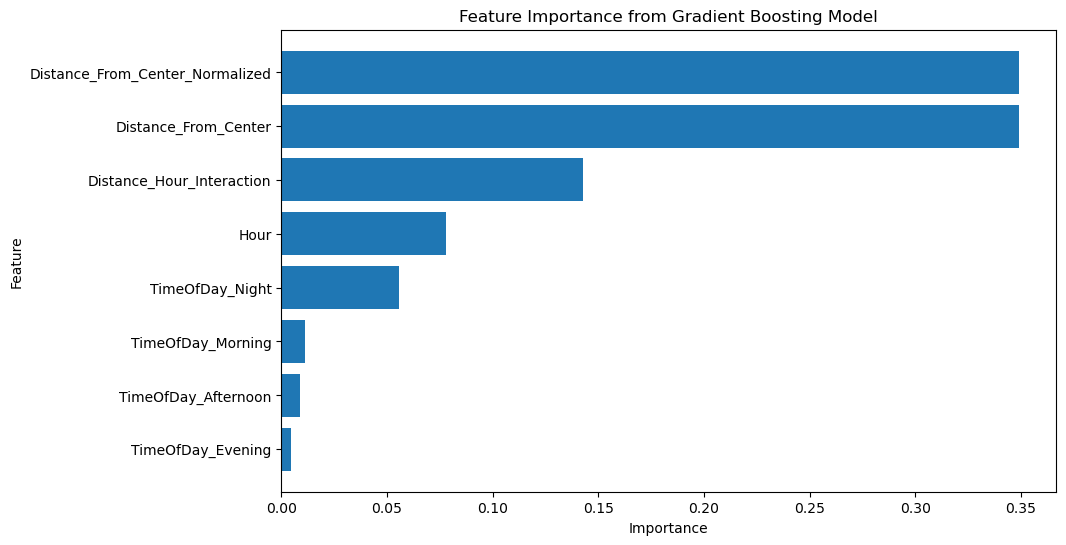

In [9]:
# feature importance analysis
import pandas as pd

# Extract feature importance from the gradient boosting model
feature_importance = pd.DataFrame({
    'Feature': engineered_features,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print("\nFeature Importance:")
print(feature_importance)

# Visualize feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Gradient Boosting Model')
plt.gca().invert_yaxis()
plt.show()

In [10]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}

# Initialize the grid search
grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_weighted',  # Optimize for weighted F1-score
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("\nBest Hyperparameters:")
print(best_params)
print("\nBest Grid Search Score (Weighted F1):")
print(best_score)

# Update the model with the best parameters
optimized_gb_model = grid_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

Best Grid Search Score (Weighted F1):
0.7773775884886741


In [17]:
print(pd.Series(y_train).value_counts())

Severity
0    1681
1    1347
Name: count, dtype: int64


In [11]:
# eg. Random Forest
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest with default settings
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)
classification_rep_rf = classification_report(y_test, y_pred_rf)
confusion_mat_rf = confusion_matrix(y_test, y_pred_rf)

print("\nRandom Forest Model Performance:")
print(classification_rep_rf)
print("\nConfusion Matrix:")
print(confusion_mat_rf)



Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82       420
           1       0.74      0.93      0.83       337

    accuracy                           0.83       757
   macro avg       0.84      0.84      0.83       757
weighted avg       0.85      0.83      0.83       757


Confusion Matrix:
[[311 109]
 [ 23 314]]


In [12]:
# address class imbalance
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample the data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution after resampling
print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Train the Gradient Boosting model with resampled data
gb_model_smote = GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
gb_model_smote.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred_smote = gb_model_smote.predict(X_test)
classification_rep_smote = classification_report(y_test, y_pred_smote)
confusion_mat_smote = confusion_matrix(y_test, y_pred_smote)

print("\nGradient Boosting Model with SMOTE Performance:")
print(classification_rep_smote)
print("\nConfusion Matrix:")
print(confusion_mat_smote)



Class distribution after SMOTE:
Severity
1    1681
0    1681
Name: count, dtype: int64

Gradient Boosting Model with SMOTE Performance:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       420
           1       0.72      0.84      0.78       337

    accuracy                           0.78       757
   macro avg       0.79      0.79      0.78       757
weighted avg       0.79      0.78      0.79       757


Confusion Matrix:
[[311 109]
 [ 54 283]]


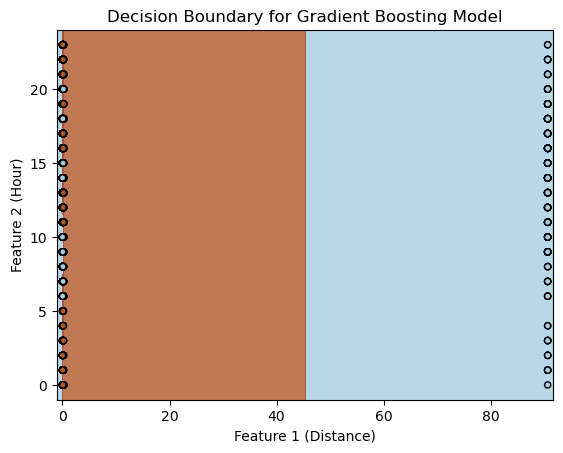

In [ ]:
# visualizing decision boundaries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

# Select only two features for visualization
X_visualize = X_train.iloc[:, :2].values  # Convert DataFrame to NumPy
y_visualize = y_train.values  # Convert target to NumPy

# Train a Gradient Boosting model with two features
gb_visualize = GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=42)
gb_visualize.fit(X_visualize, y_visualize)

# Generate a mesh grid
x_min, x_max = X_visualize[:, 0].min() - 1, X_visualize[:, 0].max() + 1
y_min, y_max = X_visualize[:, 1].min() - 1, X_visualize[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict across the grid
Z = gb_visualize.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
plt.scatter(X_visualize[:, 0], X_visualize[:, 1], c=y_visualize, edgecolor='k', s=20, cmap=plt.cm.Paired)
plt.xlabel("Feature 1 (Distance)")
plt.ylabel("Feature 2 (Hour)")
plt.title("Decision Boundary for Gradient Boosting Model")
plt.show()



Simplified Gradient Boosting Model Performance:
              precision    recall  f1-score   support

           0       0.85      0.79      0.81       420
           1       0.75      0.82      0.79       337

    accuracy                           0.80       757
   macro avg       0.80      0.80      0.80       757
weighted avg       0.81      0.80      0.80       757


Confusion Matrix:
[[330  90]
 [ 60 277]]

Simplified Feature Importance:
                     Feature  Importance
0       Distance_From_Center    0.699356
1                       Hour    0.168246
2  Distance_Hour_Interaction    0.132399


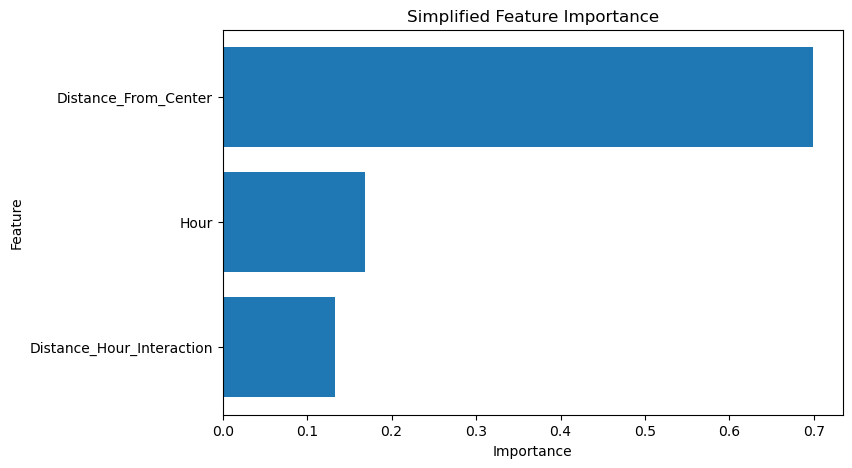

In [ ]:
# Simplify Model with Key Features
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# select the top features
simplified_features = ['Distance_From_Center', 'Hour', 'Distance_Hour_Interaction']
X_simplified = combined_data[simplified_features]
y_simplified = combined_data['Severity']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X_simplified, y_simplified, test_size=0.2, random_state=42, stratify=y_simplified)

# train the Gradient Boosting model with simplified features
simplified_gb_model = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
simplified_gb_model.fit(X_train, y_train)

# make predictions
y_pred = simplified_gb_model.predict(X_test)

# evaluate the model
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# display the results
print("\nSimplified Gradient Boosting Model Performance:")
print(classification_rep)
print("\nConfusion Matrix:")    
print(confusion_mat)

# feature importance
feature_importance = pd.DataFrame({
    'Feature': simplified_features,
    'Importance': simplified_gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nSimplified Feature Importance:")
print(feature_importance)

# visualize feature importance
plt.figure(figsize=(8, 5))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Simplified Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# train a new Gradient Boosting model with the 3 simplified features
import pickle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Select the simplified features and target
simplified_features = ["Distance_From_Center", "Hour", "Distance_Hour_Interaction"]
X_simplified = combined_data[simplified_features]
y = combined_data["Severity"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_simplified, y, test_size=0.2, random_state=42, stratify=y)

# Train a new Gradient Boosting model
gb_model_simplified = GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
gb_model_simplified.fit(X_train, y_train)

# Evaluate the new model
y_pred = gb_model_simplified.predict(X_test)
print("Simplified Model Performance:")
print(classification_report(y_test, y_pred))

# Save the simplified model
with open("simplified_gb_model.pkl", "wb") as model_file:
    pickle.dump(gb_model_simplified, model_file)


Simplified Model Performance:
              precision    recall  f1-score   support

           0       0.85      0.79      0.81       420
           1       0.75      0.82      0.79       337

    accuracy                           0.80       757
   macro avg       0.80      0.80      0.80       757
weighted avg       0.81      0.80      0.80       757

